In [1]:
%matplotlib inline


.. index:: classification, binary, ROC

Binary classification
=====================

A binary classification problem is to find
a frontier to separate two clouds of points
(see `binary classification <https://en.wikipedia.org/wiki/Binary_classification>`_).



What does it solve?
-------------------

We start by generating an artificial cloud of points.



In [2]:
from sklearn.datasets import make_classification
X, Y = make_classification(n_samples=500, n_features=2, n_classes=2,
                           n_repeated=0, n_redundant=0)

We plot the data.



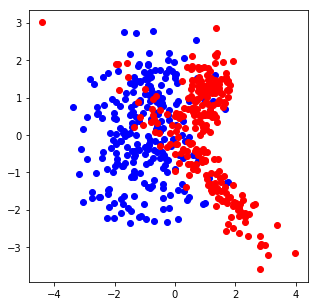

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
ax.plot(X[Y == 0, 0], X[Y == 0, 1], "ob")
ax.plot(X[Y == 1, 0], X[Y == 1, 1], "or")

We represent the data in dataframe.



In [4]:
import pandas
data = pandas.DataFrame(data=X, columns=["X1", "X2"])
data["Label"] = Y.astype(float)

From a geometrical point of view, a binary classification 
problem consists in finding the best boundary between 
two clouds of points. The simplest is to assume that it is 
a straight line. In this case, a logistic regression model 
will help us.



In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]

In [13]:
import revoscalepy

ImportError: DLL load failed: The specified module could not be found.

In [9]:
from revoscalepy import rx_logit, rx_predict
logreg = rx_logit("Label ~ X1 + X2", data=data)

ImportError: DLL load failed: The specified module could not be found.

The model produces a line boundary
whose coefficients are:



In [11]:
print(logreg.coef_)

NameError: name 'logreg' is not defined

We could trace this line but this graph
would only be valid for a linear model.
Instead we color the background of the graph with
the color of the class predicted by the model.



In [ ]:
import numpy

def colorie(X, model, ax, fig):
    if isinstance(X, pandas.DataFrame):
        X = X.as_matrix()
    xmin, xmax = numpy.min(X[:, 0]), numpy.max(X[:, 0])
    ymin, ymax = numpy.min(X[:, 1]), numpy.max(X[:, 1])
    hx = (xmax - xmin) / 100
    hy = (ymax - ymin) / 100
    xx, yy = numpy.mgrid[xmin:xmax:hx, ymin:ymax:hy]
    grid = numpy.c_[xx.ravel(), yy.ravel()]
    dfgrid = pandas.DataFrame(data=grid, columns=["X1", "X2"])
    probs = rx_predict(model, dfgrid).as_matrix()[:, 1].reshape(xx.shape)

    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])


fig = plt.figure(figsize=(7, 5))
ax = plt.subplot()
colorie(X, logreg, ax, fig)
ax.scatter(X[:, 0], X[:, 1], c=Y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")

Evaluation
----------

There are two tests that are carried out in a quasi-systematic way
for this type of problem: one :epkg:`confusion matrix`
And a curve :epkg:`ROC`.

The first step is to divide the dataset into
training set (train) and test set (test).
This is necessary because some models can simply
learn by heart reach a null error on the data
used to learn. This is the case with the
`nearest neighbors <https://en.wikipedia.org/wiki/Search_of_more_neighbourne neighbors>` _.
The division must be random. Moreover,
this can be repeated several times 
to ensure the robustness of the results.



In [7]:
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split
data_train, data_test = train_test_split(data)

We train on the training set.



In [8]:
logreg = rx_logistic_regression("Label ~ X1 + X2", data=data_train)

NameError: name 'rx_logistic_regression' is not defined

We predict on the test set.



In [ ]:
y_pred = rx_predict(logreg, data=data_test)

We compute the :epkg:`confusion matrix`.



In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(data_test["Label"], y_pred["PredictedLabel"])
print(conf)

The numbers on the diagonal indicate the observations
ranked in the right class. Elsewhere, these are the miclassified observations
These are blue dots on a red background for example.



In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot()
colorie(data_test[["X1", "X2"]], logreg, ax, fig)
ax.scatter(data_test["X1"], data_test["X2"], c=data_test["Label"], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
ax.set_title("Résultats sur la base de test")

Some points are more or less far from the boundary
the model found between the two classes. The more
a point is far from the border, the more the model is sure of its class.
This is true for logistic regression but also for most
of the models used to make a binary classification.
This is how the model is able to give an relevance indicator:
the distance between the point and the boundary the model found.
This distance is converted into a score or a probability.
The :epkg:`confusion matrix` does not use this information,
The curve :epkg:`ROC` does. Let's see how.
This is inspired by the example
`Receiver Operating Characteristic (ROC) <http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html>` _.
The curve :epkg:`ROC` is the same with scores or probabilities.



In [ ]:
print(y_pred[:5])

For a binary classification, :epkg:`microsoftml` returns 
the predicted label, a score and the probability of each
observation to be in class 1.
We build the :epkg:`ROC` curve.
The model is right if it finds the right class.
with is translated by ``y_pred["PredictedLabel"] == data_test["Label"]``.
The score is ``y_pred["Probability"]`` when the predicted class is 1,
``1 - y_pred["Probability"]`` otherwise.



In [ ]:
from sklearn.metrics import roc_curve
prob_pred = [y_pred.loc[i, "Probability"] if y_pred.loc[i, "PredictedLabel"] \
             else (1 - y_pred.loc[i, "Probability"]) for i in range(0, y_pred.shape[0])]
good = y_pred["PredictedLabel"] == (data_test["Label"] == 1)
fpr, tpr, th = roc_curve((y_pred["PredictedLabel"] == data_test["Label"]).ravel(), prob_pred)

For index ``i``, ``th[i]`` is a threshold,
``tpr[i]`` is the ratio of correclty classified observations 
with a probability higher than``th[i]``.
``fpr[i]`` is the ratio of misclassified observations
with a probability higher than``th[i]``.



In [ ]:
print("i=2", th[2], tpr[2], fpr[2])
print("i={0}".format(len(th) - 2), th[-2], tpr[-2], fpr[-2])

The lower the score is, the higher the proportion is.
When the threshold is very low, the model returns a score or a probability
always above the threshold and the two proportions are equal to 1.
If the threshold is high, the two proportions are null.
We draw the curve by using many distinct thresholds.



In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC')
plt.legend(loc="lower right")

The area under the curve or :epkg:`AUC` (Area Under the Curve)
is related to the relevance of the model.
The higher the score is, the larger the proportion of correclty classified
observations is compared to the proportion of misclassified examples. 
When these proportions are always equal whatever the threshold is,
the curve fits the first diagonal and the model
has learned nothing. The higher the curve is, the better the model is.
This is why the area under the curve is calculated.



In [ ]:
from sklearn.metrics import auc
print(auc(fpr, tpr))

The curve :epkg:`ROC` always applies to a binary decision.
The binary classification can be turned into three binary decisions:

* The model correclty classified an example, either in class 0 or class 1.
* The model correclty classified an example in class 0.
* The model correclty classified an example in class 1.

If the answers are linked, the model usually gives
different performance on these three issues.
We compute the curves :epkg:`ROC` related to these three questions.



In [ ]:
fpr_cl = dict()
tpr_cl = dict()
fpr_cl["classe 0"], tpr_cl["classe 0"], _ = roc_curve(
    1 - data_test["Label"], 1 - y_pred["Probability"])
fpr_cl["classe 1"], tpr_cl["classe 1"], _ = roc_curve(
    data_test["Label"], y_pred["Probability"])  # y_test == 1
fpr_cl["all"], tpr_cl["all"] = fpr, tpr  # We already computed this.

We plot.



In [ ]:
plt.figure()
for key in fpr_cl:
    plt.plot(fpr_cl[key], tpr_cl[key], label=key)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC(s)')
plt.legend(loc="lower right")

plt.show()